In [2]:
import sys
import copy
import time

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

from pygsp import graphs

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.architecture import GraphDecoder, GraphDeepDecoder, Ups, Upsampling
from graph_deep_decoder.graph_clustering import MultiResGraphClustering, Type_A
from graph_deep_decoder.model import Model, TVModel, LRModel, BLModel

# %matplotlib qt

SEED = 0
SAVE = False

### BL signal

In [3]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# Graph parameters
G_params = {}
G_params['type'] = ds.SBM
G_params['k'] = 8
G_params['type_z'] = ds.CONT
G_params['N'] = 256
G_params['p'] = 0.75
G_params['q'] = 0.0075

# Signal parameters
K = 3
params = 8
n_signals = 100
n_p = 0.1

# Model parameters
epochs = 500
lr = 0.001

Exps = [{'type': 'TV', 'alpha': 1, 'legend': 'TV'},
        {'type': 'LR', 'alpha': 0.1, 'legend': 'LR'},
        {'type': 'BL', 'alpha': 0.1, 'max_coefs': False, 'legend': 'BL'},
        {'type': 'BL', 'alpha': params, 'max_coefs': False, 'legend': 'BL'},
        {'type': '2LD', 'fts': 150, 'std': 1, 'H_norm': True, 'legend': '2L-GCG'},
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [256]*6, 'fts': [97]*5 + [1], 'bn': False,
         'af': nn.ReLU(), 'laf': None, 'w_std': .1, 'in_std': .001, 'H_norm': False,
         'legend': 'GCG'},
        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [8, 16, 32, 64] + [256]*2, 'fts': [97]*5 + [1],
         'af': nn.ReLU(), 'laf': None, 'w_std': 1, 'in_std': 1, 'bn': False,
         'legend': 'GD'},
        ]

G = ds.create_graph(G_params, SEED)
A = np.asarray(G.W.todense())
S = A
plt.figure()
plt.imshow(A)
Lambda, V = utils.ordered_eig(S)

# Create filter H
hs = np.random.rand(K)
hs /= np.sum(hs)
x_dw = ds.DiffusedWhiteGS(G, ds.NonLin.NONE, K, coefs=hs)
H = x_dw.H
H_norm = H/np.linalg.norm(H)

L_H, V_H = utils.ordered_eig(H)
plt.figure()
plt.stem(L_H)
plt.title('Eigvalues H')

for exp in Exps:
    if exp['type'] == '2LD':
        exp['H'] = H_norm if exp['H_norm'] else H
    elif exp['type'] == 'DD' and exp['ups'] == Ups.U_MEAN:
        clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0])
        exp['nodes'] = clt.sizes
        exp['Us'] = clt.Us
        exp['As'] = clt.As
    elif exp['type'] == 'DD' and exp['ups'] == Ups.U_MAT:
        exp['Us'] = [H_norm] if exp['H_norm'] else [H]
        exp['Us'] = exp['Us']*(len(exp['nodes'])-2) + [None] 
        exp['As'] = []

<ipython-input-3-bb47d5902e60>:66: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(L_H)


In [4]:
err1 = np.zeros((len(Exps), n_signals, epochs))
err_wrt_n3 = np.zeros((len(Exps), n_signals, epochs))
X_bl256 = np.zeros((G.N, n_signals))
weights = np.zeros(len(Exps))
start_time = time.time()
for i in range(n_signals):
    x = ds.bandlimited_signal(Lambda, V, params)
    X_bl256[:, i] = x
    x_n = ds.GraphSignal.add_noise(x, n_p)
    for j, exp in enumerate(Exps):
        if exp['type'] == 'TV':
            model = TVModel(G.W.todense(), exp['alpha'])
        elif exp['type'] == 'LR':
            model = LRModel(G.L.todense(), exp['alpha'])
        elif exp['type'] == 'BL':
            k_firsts = int(G.N*exp['alpha']) if exp['alpha'] < 1 else exp['alpha']
            model = BLModel(V, k_firsts)
        elif exp['type'] == '2LD':
            dec = GraphDecoder(exp['fts'], exp['H'], exp['std'])
            weights[j] = G.N*exp['fts']
        elif exp['type'] == 'DD':
            dec = GraphDeepDecoder(exp['fts'], exp['nodes'], exp['Us'], batch_norm=exp['bn'],
                                   As=exp['As'], act_fn=exp['af'], ups=exp['ups'],
                                   last_act_fn=exp['laf'], input_std=exp['in_std'],
                                   w_std=exp['w_std'])
            weights[j] = dec.count_params()
        else:
            raise Exception('Unkwown exp type')
        
        if exp['type'] in ['DD', '2LD']:
            model = Model(dec, epochs=epochs, learning_rate=lr)
            err_wrt_n3[j, i, :], err1[j, i, :], _ = model.fit(x_n, x)
        else:
            model.fit(x_n)
            _, err_non_train = model.test(x)
            err1[j, i, :] = np.repeat(err_non_train, epochs)
    print(i, end=' ')

print('--- {} minutes ---'.format((time.time()-start_time)/60))

<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-4-89d48be84c70>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if exp['type'] is 'TV':
<ipython-input-4-89d48be84c70>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif exp['type'] is 'LR':
<ipython-input-4-89d48be84c70>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif exp['type'] is 'BL':
<ipython-input-4-89d48be84c7

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 --- 7.728845282395681 minutes ---


In [5]:
# np.save('../results/compare_models/models_SBM8_BL',err1)
# err1 = np.load('../results/compare_models/models_SBM8_BL.npy')

In [6]:
leg = []
for i, exp in enumerate(Exps):
    txt = exp['legend']
    if exp['type'] == 'BL':
        if exp['alpha'] >= 1:
            alpha = exp['alpha']
        else:
            alpha = int(exp['alpha']*G.N)
        txt += ', K=' + str(alpha)
    leg.append(txt)

# Plots Median Error
med_mse = np.median(err1, axis=1)
fig = plt.figure()
plt.semilogy(med_mse.T, linewidth=4)
plt.legend(leg, prop={'size': 12})
plt.grid(True, which='both')
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Median Error',fontsize=18)
plt.xlim([0, epochs+1])
plt.ylim([1e-3, 2])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

if SAVE:
    path = '../results/compare_models/'
    fig.savefig(path + 'models_SBM8_BL.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


### DW-MEDIAN signals

In [11]:
err2 = np.zeros((len(Exps), n_signals, epochs))
err_wrt_n4 = np.zeros((len(Exps), n_signals, epochs))
X_dw256 = np.zeros((G.N, n_signals))
weights = np.zeros(len(Exps))
start_time = time.time()
for i in range(n_signals):
    x_dw = ds.DiffusedWhiteGS(G, ds.NonLin.MEDIAN, K)
    x_dw.to_unit_norm()
    x = x_dw.x
    X_dw256[:, i] = x
    x_n = ds.GraphSignal.add_noise(x, n_p)
    for j, exp in enumerate(Exps):
        if exp['type'] == 'TV':
            model = TVModel(G.W.todense(), exp['alpha'])
        elif exp['type'] == 'LR':
            model = LRModel(G.L.todense(), exp['alpha'])
        elif exp['type'] == 'BL':
            k_firsts = int(G.N*exp['alpha']) if exp['alpha'] < 1 else exp['alpha']
            model = BLModel(V, k_firsts)
        elif exp['type'] == '2LD':
            dec = GraphDecoder(exp['fts'], exp['H'], exp['std'])
            weights[j] = G.N*exp['fts']
        elif exp['type'] == 'DD':
            dec = GraphDeepDecoder(exp['fts'], exp['nodes'], exp['Us'], batch_norm=exp['bn'],
                                   As=exp['As'], act_fn=exp['af'], ups=exp['ups'],
                                   last_act_fn=exp['laf'], input_std=exp['in_std'],
                                   w_std=exp['w_std'])
            weights[j] = dec.count_params()
        else:
            raise Exception('Unkwown exp type')
        
        if exp['type'] in ['DD', '2LD']:
            model = Model(dec, epochs=epochs, learning_rate=lr)
            err_wrt_n4[j, i, :], err2[j, i, :], _ = model.fit(x_n, x)
        else:
            model.fit(x_n)
            _, err_non_train = model.test(x)
            err2[j, i, :] = np.repeat(err_non_train, epochs)
    
    print(i, end = ' ')

print('--- {} minutes ---'.format((time.time()-start_time)/60))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 --- 7.9754852215449015 minutes ---


In [12]:
# np.save('../results/compare_models/models_SBM8_DW',err2)
# err2 = np.load('../results/compare_models/models_SBM8_DW.npy')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


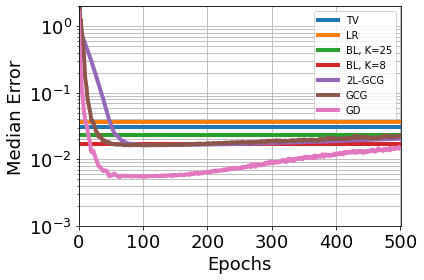

In [10]:
leg = []
for i, exp in enumerate(Exps):
    txt = exp['legend']
    if exp['type'] == 'BL':
        if exp['alpha'] >= 1:
            alpha = exp['alpha']
        else:
            alpha = int(exp['alpha']*G.N)
        txt += ', K=' + str(alpha)
    leg.append(txt)
    
# Plots Median Error
med_mse = np.median(err2, axis=1)
fig = plt.figure()
plt.semilogy(med_mse.T, linewidth=4)
plt.legend(leg, prop={'size': 10})
plt.grid(True, which='both')
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Median Error',fontsize=18)
plt.xlim([0, epochs+1])
plt.ylim([1e-3, 2])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

if SAVE:
    path = '../results/compare_models/'
    fig.savefig(path + 'models_SBM8_DW.eps')

In [ ]:
plt.show()